### 动机
+ 一个好的模型需要对输入数据的扰动鲁棒
    + 使用有噪音的数据等价于 Tikhonov 正则
    + 丢弃法：在**层之间**加入噪音（注意）

### 无偏差地加入噪音
+ 对 $\mathbf{x}$ 加入噪音得到 $\mathbf{x}$ ，我们希望：$\mathbf{E}\left[\mathbf{x}^{\prime}\right]=\mathbf{x}$ （也就是说虽然我加了噪音，但是我希望不要改变我的期望，就是平均下来这个值还是对的）
+ 丢弃法对每个元素进行如下扰动：$x_{i}^{\prime}=\left\{\begin{array}{ll}
0 & \text { with probablity } p \\
\frac{x_{i}}{1-p} & \text { otherise }
\end{array}\right.$ （丢弃法在做什么？我给定一个概率 p,在 p 的概率里，我把原始输入 $X_i$ 变成 0 ，在剩下的地方除以 1-p，说白了就是把原始输入变大一点（因为 1-p <1 ））
+ 关于为什么期望是不变的：$E\left[x_{i}^{\prime}\right]=p \cdot 0+(1-p) \frac{x_{i}}{1-p}$ 消掉之后最终还是等于 $x_{i}$

### 理论总结
+ 丢弃法将一些输出项**随机置 0** 来控制模型复杂度
+ 常作用在多层感知机的隐藏层输出上
+ *丢弃概率* 是控制模型复杂度的超参数

## 从零开始实现
我们从均匀分布U[0, 1]中抽取样本，样本数与这层神经⽹络的维度⼀致。然后我
们保留那些对应样本⼤于p的节点，把剩下的丢弃。

In [12]:
import torch
from torch import nn
from d2l import torch as d2l

# 实现 dropout_layer 函数，该函数以 dropout 的概率丢弃张量输入 x 中的元素
def dropout_layer(X, dropout):
    # assert 断言，判断 assert 后的表达式是否为 True ，若为 True 则继续执行下面的代码
    # 若为 False ，则触发异常
    assert 0 <= dropout <= 1
    # 在本情况下，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况下，所有元素都被保留
    if dropout == 0:
        return X
    mask  = (torch.rand(X.shape) > dropout).float()
    # mask 可以理解为 一个布尔型的张量，每一个值表示 X 对应下标的值是否要 dropout
    return mask * X / (1.0 - dropout)

我们可以通过下⾯⼏个例⼦来测试dropout_layer函数。我们将输⼊X通过暂退法操作，暂退概率分别为0、
0.5和1。

In [13]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.)) # 所有元素都被保留
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.)) # 所有元素都被丢弃

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  4.,  6.,  8., 10., 12., 14.],
        [16.,  0.,  0., 22., 24.,  0.,  0., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


## 定义具有两个隐藏层的多层感知机，每个隐藏层包含 256 个单元

In [14]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
dropout1, dropout2 = 0.2, 0.5
class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使⽤dropout
        if self.training == True:
        # 在第⼀个全连接层之后添加⼀个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第⼆个全连接层之后添加⼀个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

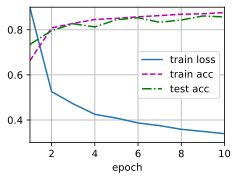

In [15]:
## 训练和测试
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)


## 简洁实现

In [20]:
net = nn.Sequential(
    nn.Flatten(), nn.Linear(784, 256), nn.ReLU(),
    nn.Dropout(dropout1), nn.Linear(256, 256), nn.ReLU(),
    nn.Dropout(dropout2), nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights)

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

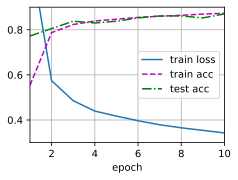

In [21]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)


### ELSE
为什么dropout会有用？
直接的想法是这样子：

在training的时候，会丢掉一些neuron，就好像是你要练轻功的时候，会在脚上绑一些重物；然后，你在实际战斗的时候，就是实际testing的时候，是没有dropout的，就相当于把重物拿下来，所以你就会变得很强